# Data Preprocessing

In [4]:
import pandas as pd
import numpy as np
import pycountry

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Clean the Technology Readiness Index Dataset

In [5]:
## Load the Technology Readiness Index dataset into a DataFrame
df_tri = pd.read_csv('Data/Technology_Readiness_Index.csv')

# Only keep the columns 'Economy_Label', 'Category_Label', '2015_Index_Value' and '2016_Index_Value'
df_tri = df_tri[['Economy_Label', 'Category_Label', '2015_Index_Value', '2016_Index_Value']]

# Add a column with the average index value for 2015 and 2016
df_tri['Average_Index_Value'] = df_tri[['2015_Index_Value', '2016_Index_Value']].mean(axis=1)

# Delete the 2015 and 2016 index value columns
df_tri.drop(columns=['2015_Index_Value', '2016_Index_Value'], inplace=True)

# Pivot the dataframe
df_tri_cleaned = df_tri.pivot(index='Economy_Label', columns='Category_Label', values=['Average_Index_Value'])

# Flatten the multi-level column index
df_tri_cleaned.columns = ['_'.join(col).strip() for col in df_tri_cleaned.columns.values]

# Delete the row with 'Economy_Label'
df_tri_cleaned.reset_index(inplace=True)

# Rename the columns
df_tri_cleaned.columns = ['Country', 'Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills']

# Drop missing values
df_tri_cleaned.dropna(inplace=True)

# Change the 'Country' column to ISO codes
# Extract the 'Country' column as a list
country_names = df_tri_cleaned['Country'].tolist()

# Create a mapping of country names to ISO codes
country_to_iso = {}
for country in country_names:
    try:
        # Get the country object using the name
        country_obj = pycountry.countries.lookup(country)
        # Map country name to ISO code
        country_to_iso[country] = country_obj.alpha_3  # Using 3-letter ISO code
    except LookupError:
        # If the country is not found, handle it as needed
        print(f"Country not found: {country}")

# Manual mapping for countries that did not get an ISO code
manual_iso_mapping = {
    "Bolivia (Plurinational State of)": "BOL",
    "China, Hong Kong SAR": "HKG",
    "Congo, Dem. Rep. of the": "COD",
    "Cote d'Ivoire": "CIV",
    "Iran (Islamic Republic of)": "IRN",
    "Lao People's Dem. Rep.": "LAO",
    "Netherlands (Kingdom of the)": "NLD",
    "Switzerland, Liechtenstein": "CHE",
    "Turkiye": "TUR",
    "Venezuela (Bolivarian Rep. of)": "VEN"
}

# Update the mapping with the manual mappings
country_to_iso.update(manual_iso_mapping)

# Create a Series from the mapping to use for replacing values
iso_codes_series = pd.Series(country_to_iso)

# Replace the 'Country' column values with ISO codes
df_tri_cleaned['Country'] = df_tri_cleaned['Country'].replace(iso_codes_series)

df_tri_cleaned.head()

Country not found: Bolivia (Plurinational State of)
Country not found: China, Hong Kong SAR
Country not found: Congo, Dem. Rep. of the
Country not found: Cote d'Ivoire
Country not found: Iran (Islamic Republic of)
Country not found: Lao People's Dem. Rep.
Country not found: Netherlands (Kingdom of the)
Country not found: Switzerland, Liechtenstein
Country not found: Turkiye
Country not found: Venezuela (Bolivarian Rep. of)


,Country,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills
0,AFG,0.15,0.00,0.25,0.00,0.00,0.10
1,ALB,0.60,0.50,0.50,0.40,0.10,0.45
2,DZA,0.50,0.25,0.20,0.30,0.30,0.40
3,AGO,0.50,0.10,0.25,0.15,0.05,0.20
4,ARG,0.40,0.55,0.60,0.55,0.30,0.65


In [6]:
df_tri_cleaned.describe()

,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,0.628614,0.423494,0.574699,0.450904,0.246084,0.432229
std,0.180766,0.249768,0.193199,0.262648,0.240580,0.238875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.200000,0.400000,0.200000,0.050000,0.212500
50%,0.650000,0.450000,0.600000,0.400000,0.150000,0.400000
75%,0.750000,0.600000,0.700000,0.650000,0.400000,0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Clean the Road Traffic Deaths Sex Dataset

In [7]:
## Load the Road Traffic Deaths Sex dataset into a DataFrame
df_rtds = pd.read_csv('Data/Road_Traffic_Deaths_Sex.csv')

# Only keep the columns 'Unnamed: 0', 'Unnamed: 1', 'Estimated road traffic death rate (per 100 000 population)', 'Estimated road traffic death rate (per 100 000 population).1' and 'Estimated road traffic death rate (per 100 000 population).2'
df_rtds = df_rtds[['Unnamed: 0', 'Unnamed: 1', 'Estimated road traffic death rate (per 100 000 population)', 'Estimated road traffic death rate (per 100 000 population).1', 'Estimated road traffic death rate (per 100 000 population).2']]

# Rename the columns and delete the first row
df_rtds.columns = ['Country', 'Year', 'Total', 'Males', 'Females']
df_rtds = df_rtds.iloc[1:]

# Only keep the rows where the 'Year' column is '2015' or '2016'
df_rtds['Year'] = df_rtds['Year'].str.strip()
df_rtds = df_rtds[df_rtds['Year'].isin(['2015', '2016'])]

# Remove the numbers between square brackets
columns_to_clean = ['Total','Males','Females']

for col in columns_to_clean:
    df_rtds[col] = df_rtds[col].str.replace(r'\s*\[.*?\]', '', regex=True)

# Convert the death rate columns to numeric
df_rtds['Total'] = pd.to_numeric(df_rtds['Total'], errors='coerce')
df_rtds['Males'] = pd.to_numeric(df_rtds['Males'], errors='coerce')
df_rtds['Females'] = pd.to_numeric(df_rtds['Females'], errors='coerce')
df_rtds['Year'] = pd.to_numeric(df_rtds['Year'], errors='coerce')

# Group by 'Country' and calculate the mean for the last three columns for '2015' and '2016'
df_rtds = df_rtds.groupby('Country').mean()[['Total','Males','Females']]

# Normalize the last three columns
# Convert columns to numeric type
columns_to_normalize = ['Total','Males','Females']

for col in columns_to_normalize:
    df_rtds[col] = pd.to_numeric(df_rtds[col])

# Min-Max Normalization directly in the existing DataFrame
#for col in columns_to_normalize:
#    df_rtds[col] = (df_rtds[col] - df_rtds[col].min()) / (df_rtds[col].max() - df_rtds[col].min())

# Reset the index so that "Country" becomes a regular column
df_rtds = df_rtds.reset_index()

# Change the 'Country' column to ISO codes
# Extract the 'Country' column as a list
country_names = df_rtds['Country'].tolist()

# Create a mapping of country names to ISO codes
country_to_iso = {}
for country in country_names:
    try:
        # Get the country object using the name
        country_obj = pycountry.countries.lookup(country)
        # Map country name to ISO code
        country_to_iso[country] = country_obj.alpha_3  # Using 3-letter ISO code
    except LookupError:
        # If the country is not found, handle it as needed
        print(f"Country not found: {country}")

# Manual mapping for countries that did not get an ISO code
manual_iso_mapping = {
    "Bolivia (Plurinational State of)": "BOL",
    "Cote d'Ivoire": "CIV",
    "Democratic Republic of the Congo": "COD",
    "Iran (Islamic Republic of)": "IRN",
    "Micronesia (Federated States of)": "FSM",
    "Netherlands (Kingdom of the)": "NLD",
    "Republic of Korea": "KOR",
    "Turkiye": "TUR",
    "Venezuela (Bolivarian Republic of)": "VEN"
}

# Update the mapping with the manual mappings
country_to_iso.update(manual_iso_mapping)

# Create a Series from the mapping to use for replacing values
iso_codes_series = pd.Series(country_to_iso)

# Replace the 'Country' column values with ISO codes
df_rtds['Country'] = df_rtds['Country'].replace(iso_codes_series)

df_rtds.head(10)


Country not found: Bolivia (Plurinational State of)
Country not found: Cote d'Ivoire
Country not found: Democratic Republic of the Congo
Country not found: Iran (Islamic Republic of)
Country not found: Micronesia (Federated States of)
Country not found: Netherlands (Kingdom of the)
Country not found: Republic of Korea
Country not found: Turkiye
Country not found: Venezuela (Bolivarian Republic of)


,Country,Total,Males,Females
0,AFG,14.60,22.90,5.75
1,ALB,13.80,20.90,6.45
2,DZA,21.15,28.40,13.70
3,AGO,24.15,30.80,17.75
4,ATG,0.00,0.00,0.00
5,ARG,14.00,22.35,6.00
6,ARM,16.20,25.10,8.35
7,AUS,5.40,7.80,2.95
8,AUT,5.45,7.95,3.00
9,AZE,9.50,15.25,3.80


In [8]:
df_rtds.describe()

,Total,Males,Females
count,183.000000,183.000000,183.000000
mean,17.063934,25.370765,8.760383
std,9.388973,13.848550,5.802119
min,0.000000,0.000000,0.000000
25%,9.500000,14.450000,4.175000
50%,16.050000,24.250000,7.250000
75%,24.775000,35.500000,13.025000
max,39.300000,64.400000,23.900000


## Clean the Road Traffic Deaths User Dataset

In [9]:
## Read the Road Traffic Deaths Sex dataset into a DataFrame
df_rtdsfu = pd.read_csv('Data/Road_Traffic_Deaths_Sex.csv')

## Read the Road Traffic Deaths User dataset into a DataFrame
df_rtdu = pd.read_csv('Data/Road_Traffic_Deaths_User.csv')

# Only keep the columns 'Unnamed: 0' and 'Estimated number of road traffic deaths'
df_rtdsfu = df_rtdsfu[['Unnamed: 0','Unnamed: 1','Estimated road traffic death rate (per 100 000 population)']]

# Rename the columns and delete the first row
df_rtdsfu.columns = ['Country', 'Year','Total']
df_rtdsfu = df_rtdsfu.iloc[1:]

# Only keep the rows where the 'Year' column is '2016'
df_rtdsfu['Year'] = df_rtdsfu['Year'].str.strip()
df_rtdsfu = df_rtdsfu[df_rtdsfu['Year'].isin(['2016'])]

# Remove the numbers between square brackets
df_rtdsfu['Total'] = df_rtdsfu['Total'].str.replace(r'\s*\[.*?\]', '', regex=True)

# Delete the 'Year' column
df_rtdsfu.drop(columns=['Year'], inplace=True)

# Only keep the columns 'Unnamed: 0','Unnamed: 1', 'Distribution of road traffic deaths by type of road user (%)' and 'Distribution of road traffic deaths by type of road user (%).3'
df_rtdu = df_rtdu[['Unnamed: 0','Unnamed: 1','Distribution of road traffic deaths by type of road user (%)', 'Distribution of road traffic deaths by type of road user (%).3']]

# Rename the columns and delete the first row
df_rtdu.columns = ['Country', 'Year','Passengers', 'Pedestrians']
df_rtdu = df_rtdu.iloc[1:]

# Only keep the rows where the 'Year' column is '2016'
df_rtdu['Year'] = df_rtdu['Year'].str.strip()
df_rtdu = df_rtdu[df_rtdu['Year'].isin(['2016'])]

# Remove the 'h' from the 'Passengers' column
df_rtdu['Passengers'] = df_rtdu['Passengers'].str.replace('h', '', regex=False)

# Delete missing values
df_rtdu.dropna(inplace=True)

# Add the column 'Estimated_number_of_road_traffic_deaths' from the 'df_rtdsfu' DataFrame to the 'df_rtdu' DataFrame
df_rtdu_cleaned = pd.merge(df_rtdu, df_rtdsfu, on='Country', how='inner')

# Convert the 'Passengers', 'Pedestrians' and 'Total' columns to numeric
df_rtdu_cleaned['Passengers'] = pd.to_numeric(df_rtdu_cleaned['Passengers'], errors='coerce')
df_rtdu_cleaned['Pedestrians'] = pd.to_numeric(df_rtdu_cleaned['Pedestrians'], errors='coerce')
df_rtdu_cleaned['Total'] = pd.to_numeric(df_rtdu_cleaned['Total'], errors='coerce')

# Add a column with the estimated number of road traffic deaths for passengers and pedestrians
df_rtdu_cleaned['Passengers'] = df_rtdu_cleaned['Passengers']/100 * df_rtdu_cleaned['Total']
df_rtdu_cleaned['Pedestrians'] = df_rtdu_cleaned['Pedestrians']/100 * df_rtdu_cleaned['Total']

# Delete the 'Year' and 'Total' column
df_rtdu_cleaned.drop(columns=['Year','Total'], inplace=True)

# Convert columns to numeric type
columns_to_normalize = ['Passengers','Pedestrians']

for col in columns_to_normalize:
    df_rtdu_cleaned[col] = pd.to_numeric(df_rtdu_cleaned[col])

# Min-Max Normalization directly in the existing DataFrame
#for col in columns_to_normalize:
#    df_rtdu_cleaned[col] = (df_rtdu_cleaned[col] - df_rtdu_cleaned[col].min()) / (df_rtdu_cleaned[col].max() - df_rtdu_cleaned[col].min())

# Change the 'Country' column to ISO codes
# Extract the 'Country' column as a list
country_names = df_rtdu_cleaned['Country'].tolist()

# Create a mapping of country names to ISO codes
country_to_iso = {}
for country in country_names:
    try:
        # Get the country object using the name
        country_obj = pycountry.countries.lookup(country)
        # Map country name to ISO code
        country_to_iso[country] = country_obj.alpha_3  # Using 3-letter ISO code
    except LookupError:
        # If the country is not found, handle it as needed
        print(f"Country not found: {country}")

# Manual mapping for countries that did not get an ISO code
manual_iso_mapping = {
    "Bolivia (Plurinational State of)": "BOL",
    "Cote d'Ivoire": "CIV",  # Côte d'Ivoire
    "Democratic Republic of the Congo": "COD",
    "Iran (Islamic Republic of)": "IRN",
    "Micronesia (Federated States of)": "FSM",
    "Netherlands (Kingdom of the)": "NLD",
    "Republic of Korea": "KOR"  # Use KOR for South Korea
}

# Update the mapping with the manual mappings
country_to_iso.update(manual_iso_mapping)

# Create a Series from the mapping to use for replacing values
iso_codes_series = pd.Series(country_to_iso)

# Replace the 'Country' column values with ISO codes
df_rtdu_cleaned['Country'] = df_rtdu_cleaned['Country'].replace(iso_codes_series)

df_rtdu_cleaned.tail(10)

Country not found: Bolivia (Plurinational State of)
Country not found: Cote d'Ivoire
Country not found: Democratic Republic of the Congo
Country not found: Iran (Islamic Republic of)
Country not found: Micronesia (Federated States of)
Country not found: Netherlands (Kingdom of the)
Country not found: Republic of Korea


,Country,Passengers,Pedestrians
107,THA,15.1450,2.4700
108,TON,10.2884,4.9484
109,TTO,5.9160,3.7320
110,TUN,4.9910,5.6580
111,UGA,10.3360,12.0080
112,UKR,7.4120,5.6984
113,ARE,8.2698,4.3497
114,GBR,1.1550,0.7110
115,TZA,19.5534,9.1494
116,USA,3.9603,1.9737


In [10]:
df_rtdu_cleaned.describe()

,Passengers,Pedestrians
count,117.000000,117.000000
mean,5.613485,4.193465
std,4.716367,3.757972
min,0.000000,0.000000
25%,2.277600,1.435000
50%,4.167600,3.633300
75%,7.126200,5.567100
max,19.553400,17.792500


## Clean the Moral Machine Dataset

In [11]:
# Load the 'ExtendedSessionID' column from the Moral Machine dataset into a DataFrame
extendedsessionid = pd.read_csv('Data/SharedResponses.csv', usecols=['ExtendedSessionID'])

In [12]:
# Filter out the sessions that have between 24 and 26 responses
session_counts = extendedsessionid['ExtendedSessionID'].value_counts()
ids_to_keep = session_counts[(session_counts >= 24) & (session_counts <= 26)].index

print(f"Number of session ids to keep: {len(ids_to_keep)}")

Number of session ids to keep: 1105760


In [13]:
df_mm = pd.read_csv('Data/SharedResponses.csv', chunksize=500_000, dtype=str, low_memory=False)

cleaned_chunks = []
for i, chunk in enumerate(df_mm):
    print(f"Processing chunk {i+1}")

    # Cleaning
    chunk_cleaned = chunk[chunk['ExtendedSessionID'].isin(ids_to_keep)]
    chunk_cleaned = chunk_cleaned.drop(columns=['ScenarioOrder', 'Intervention', 'ScenarioType', 'DefaultChoice', 'NonDefaultChoice', 'DefaultChoiceIsOmission', 'Template','DescriptionShown','LeftHand'])
    chunk_cleaned.rename(columns={'UserCountry3': 'Country'}, inplace=True)
    chunk_cleaned = chunk_cleaned.dropna()
    chunk_cleaned = chunk_cleaned.drop_duplicates()
    chunk_cleaned = chunk_cleaned.merge(df_tri_cleaned, on='Country', how='inner').merge(df_rtds, on='Country', how='inner').merge(df_rtdu_cleaned, on='Country', how='inner')
    chunk_cleaned[['ResponseID', 'ExtendedSessionID', 'UserID', 'AttributeLevel','ScenarioTypeStrict']] = chunk_cleaned[['ResponseID', 'ExtendedSessionID', 'UserID', 'AttributeLevel','ScenarioTypeStrict']].astype(str)
    chunk_cleaned[["PedPed", "Barrier", "CrossingSignal", "NumberOfCharacters", "DiffNumberOFCharacters", "Man", "Woman", "Pregnant", "Stroller", "OldMan", "OldWoman", "Boy", "Girl", "Homeless", "LargeWoman", "LargeMan", "Criminal", "MaleExecutive", "FemaleExecutive", "FemaleAthlete", "MaleAthlete", "FemaleDoctor", "MaleDoctor", "Dog", "Cat", "Saved"]] = chunk_cleaned[["PedPed", "Barrier", "CrossingSignal", "NumberOfCharacters", "DiffNumberOFCharacters", "Man", "Woman", "Pregnant", "Stroller", "OldMan", "OldWoman", "Boy", "Girl", "Homeless", "LargeWoman", "LargeMan", "Criminal", "MaleExecutive", "FemaleExecutive", "FemaleAthlete", "MaleAthlete", "FemaleDoctor", "MaleDoctor", "Dog", "Cat", "Saved"]].astype(float).round().astype('int8')
    chunk_cleaned[["Finance_access", "ICT", "Industry_activity", "Overall_index", "Research_and_development", "Skills", "Total", "Males", "Females", "Passengers", "Pedestrians"]] = chunk_cleaned[["Finance_access", "ICT", "Industry_activity", "Overall_index", "Research_and_development", "Skills", "Total", "Males", "Females", "Passengers", "Pedestrians"]].astype('float32')

    # Append cleaned chunk
    cleaned_chunks.append(chunk_cleaned)
    print(f"Finished processing chunk {i+1}")

    # Stop after processing five chunks
    #j = 5
    #if i + 1 == j:
    #    print(f"Stopping after processing {j} chunks")
    #    break

print("All chunks have been processed")

Processing chunk 1
Finished processing chunk 1
Processing chunk 2
Finished processing chunk 2
Processing chunk 3
Finished processing chunk 3
Processing chunk 4
Finished processing chunk 4
Processing chunk 5
Finished processing chunk 5
Processing chunk 6
Finished processing chunk 6
Processing chunk 7
Finished processing chunk 7
Processing chunk 8
Finished processing chunk 8
Processing chunk 9
Finished processing chunk 9
Processing chunk 10
Finished processing chunk 10
Processing chunk 11
Finished processing chunk 11
Processing chunk 12
Finished processing chunk 12
Processing chunk 13
Finished processing chunk 13
Processing chunk 14
Finished processing chunk 14
Processing chunk 15
Finished processing chunk 15
Processing chunk 16
Finished processing chunk 16
Processing chunk 17
Finished processing chunk 17
Processing chunk 18
Finished processing chunk 18
Processing chunk 19
Finished processing chunk 19
Processing chunk 20
Finished processing chunk 20
Processing chunk 21
Finished processin

In [14]:
cleaned_data = pd.concat(cleaned_chunks, ignore_index=True)

In [15]:
responseid_counts = cleaned_data['ResponseID'].value_counts()
responseid_to_keep = responseid_counts[responseid_counts == 2].index

In [16]:
cleaned_data = cleaned_data[cleaned_data['ResponseID'].isin(responseid_to_keep)]

In [17]:
# Get the value counts for each ExtendedSessionID
session_counts = cleaned_data['ExtendedSessionID'].value_counts()

# Step 1: Calculate the counts for 26, 25, and 24 occurrences
count_26 = (session_counts == 26).sum()
count_25 = (session_counts == 25).sum()
count_24 = (session_counts == 24).sum()

# Step 2: Set the target number of rows (10 million)
target_rows = 10_000_000

# Step 3: Calculate the number of rows if we keep all ExtendedSessionIDs appearing 26 times
rows_from_26 = count_26 * 26

# Step 4: If keeping all ExtendedSessionIDs appearing 26 times keeps us under the target:
if rows_from_26 <= target_rows:
    # Keep all ExtendedSessionIDs appearing 26 times
    ids_to_keep = session_counts[session_counts == 26].index
    remaining_rows = target_rows - rows_from_26

    # Step 5: Calculate the number of rows if we also keep all ExtendedSessionIDs appearing 25 times
    rows_from_25 = count_25 * 25
    if rows_from_25 <= remaining_rows:
        # Keep all ExtendedSessionIDs appearing 25 times
        ids_to_keep = ids_to_keep.union(session_counts[session_counts == 25].index)
        remaining_rows -= rows_from_25

        # Step 6: Calculate the number of rows if we also keep all ExtendedSessionIDs appearing 24 times
        rows_from_24 = count_24 * 24
        if rows_from_24 <= remaining_rows:
            # Keep all ExtendedSessionIDs appearing 24 times
            ids_to_keep = ids_to_keep.union(session_counts[session_counts == 24].index)
        else:
            # Keep only enough ExtendedSessionIDs appearing 24 times to reach the target
            num_to_keep_24 = remaining_rows // 24
            ids_to_keep = ids_to_keep.union(session_counts[session_counts == 24].index[:num_to_keep_24])
    else:
        # Keep only enough ExtendedSessionIDs appearing 25 times to reach the target
        num_to_keep_25 = remaining_rows // 25
        ids_to_keep = ids_to_keep.union(session_counts[session_counts == 25].index[:num_to_keep_25])
else:
    # Keep only enough ExtendedSessionIDs appearing 26 times to reach the target
    num_to_keep_26 = target_rows // 26
    ids_to_keep = session_counts[session_counts == 26].index[:num_to_keep_26]

# Step 7: Filter the original dataset to keep only the selected ExtendedSessionIDs
filtered_sessions = extendedsessionid[extendedsessionid['ExtendedSessionID'].isin(ids_to_keep)]
filtered_sessions = (filtered_sessions['ExtendedSessionID'].unique()).tolist()
print(type(filtered_sessions))

# Display the filtered dataset
print(len(filtered_sessions))

<class 'list'>
412256


In [18]:
cleaned_data = cleaned_data[cleaned_data['ExtendedSessionID'].isin(filtered_sessions)]

In [19]:
cleaned_data = cleaned_data.drop(['ResponseID', 'ExtendedSessionID', 'UserID', 'Country'], axis=1)

In [20]:
cleaned_data.to_csv('Data/cleaned_data.csv', index=False)

# Data preparation and K-prototype

In [21]:
# Split dataset in features and target variable
X = cleaned_data.drop(columns=['Saved'])  # Features
y = cleaned_data['Saved'] # Target variable

In [22]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = 42)
print(X_trainval.shape, X_test.shape)

(7999993, 38) (1999999, 38)


In [23]:
# Normalize the numerical columns
num_cols = ['NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills', 'Total', 'Males', 'Females', 'Passengers', 'Pedestrians']

scaler = StandardScaler()
X_trainval[num_cols] = scaler.fit_transform(X_trainval[num_cols])

X_test[num_cols] = scaler.transform(X_test[num_cols])

In [24]:
pd.set_option('display.max_columns', None)
X_trainval.head()

,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians
23081870,0,1,0,Fat,Fitness,0.680955,-0.48336,2.858904,1.166067,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,-0.276757,-0.350111,1.921810,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-0.158134,0.997064,1.252200,0.266150,0.296519,0.191499,-0.952693,-0.901704,-1.014615,-0.860289,-0.952061
20082605,1,0,0,Hoomans,Species,0.006573,-0.48336,-0.525177,1.166067,-0.233518,-0.227887,1.579548,-0.359286,-0.349827,-0.350035,-0.276757,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,2.749912,-0.288263,-0.299737,-0.299477,0.806499,0.997064,0.062016,0.266150,0.063089,1.004092,-1.198451,-1.116885,-1.309995,-1.340899,-0.861784
14725750,0,1,0,Hoomans,Species,0.680955,-0.48336,-0.525177,-0.525297,-0.233518,3.768232,1.579548,-0.359286,1.920970,-0.350035,-0.276757,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,1.583111,-0.288175,-0.288263,-0.299737,-0.299477,0.806499,-0.200055,0.062016,0.995060,1.230240,0.191499,0.679138,0.512341,1.137444,0.440151,0.289654
6343413,1,0,0,Low,Social Status,0.680955,-0.48336,-0.525177,-0.525297,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,10.280874,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-1.122767,-1.796215,-1.128169,-1.191670,-0.637201,-1.433684,2.222496,2.485855,1.095247,0.856955,1.774386
13547396,1,0,2,Hoomans,Species,1.355337,-0.48336,-0.525177,-0.525297,7.592350,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,2.362651,-0.350111,-0.350209,-0.227449,5.486334,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-0.158134,0.997064,1.252200,0.630605,-0.170341,1.004092,-1.031335,-0.987776,-1.099009,-1.157416,-1.191340


In [25]:
train_array = X_trainval.values
test_array = X_test.values

In [26]:
np.set_printoptions(threshold=np.inf)
print(train_array[:1])

[[0 1 0 'Fat' 'Fitness' 0.68095463514328 -0.48335957527160645
  2.8589038848876953 1.1660665273666382 -0.23351825773715973
  -0.2278868407011032 -0.3590037226676941 -0.35928595066070557
  -0.34982651472091675 -0.3500354290008545 -0.2767573297023773
  -0.35011088848114014 1.9218095541000366 -0.22744908928871155
  -0.3046092987060547 -0.3050015866756439 -0.3587993085384369
  -0.3586505353450775 -0.2881753742694855 -0.2882632315158844
  -0.299736887216568 -0.2994770109653473 -0.1581338793039322
  0.9970644116401672 1.2522003650665283 0.2661497890949249
  0.2965192496776581 0.19149945676326752 -0.9526931047439575
  -0.9017041325569153 -1.0146147012710571 -0.8602889776229858
  -0.9520610570907593]]


In [27]:
# Change the data types for K-prototype clustering
# Convert the 4th (index 3) and 5th (index 4) indices to string
train_array[:, 3] = train_array[:, 3].astype(str)
train_array[:, 4] = train_array[:, 4].astype(str)

test_array[:, 3] = test_array[:, 3].astype(str)
test_array[:, 4] = test_array[:, 4].astype(str)

num_rows, num_cols = train_array.shape

# Convert all columns to float except the 4th (index 3) and 5th (index 4)
for i in range(num_cols):
    if i != 3 and i != 4:  # Exclude the 3rd and 4th columns
        train_array[:, i] = train_array[:, i].astype(float)
        test_array[:, i] = test_array[:, i].astype(float)

Processed 2 clusters with cost: 3095016.10
Processed 3 clusters with cost: 2835286.20
Processed 4 clusters with cost: 2730427.92
Processed 5 clusters with cost: 2651057.03
Processed 6 clusters with cost: 2568200.42
Processed 7 clusters with cost: 2504491.58
Processed 8 clusters with cost: 2441405.06
Processed 9 clusters with cost: 2390713.33
Processed 10 clusters with cost: 2339977.73


[]

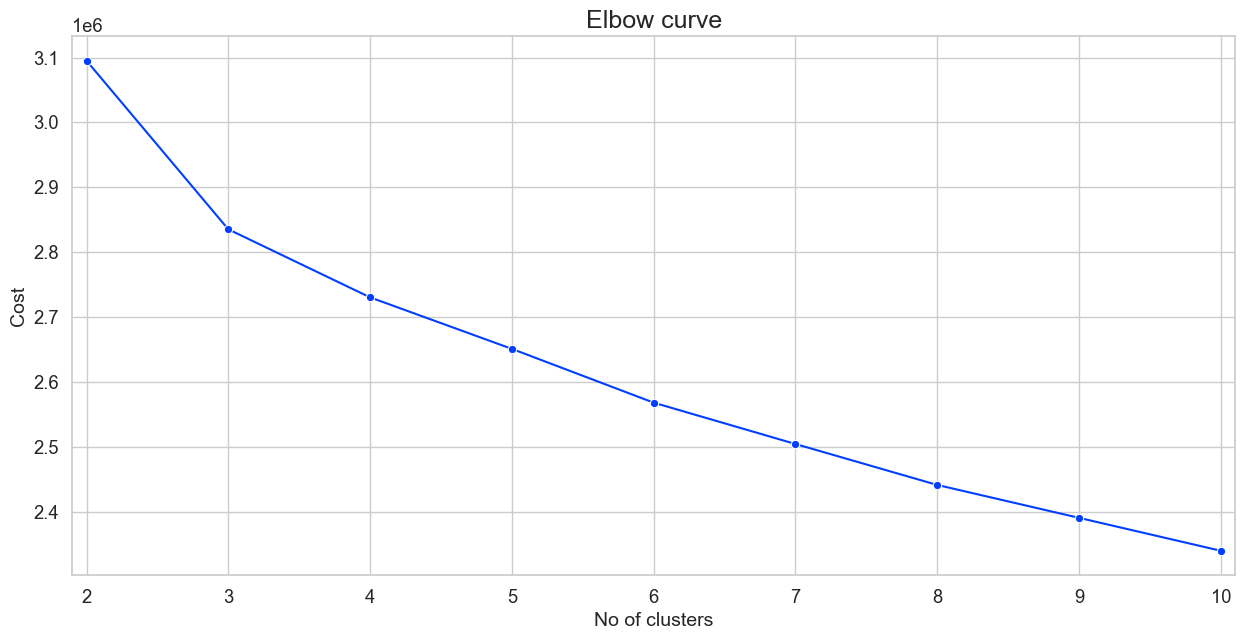

In [28]:
# Finding the optimal number of clusters by plotting the elbow curve
no_of_clusters = list(range(2, 11))
cost_values = []

indices = np.random.choice(train_array.shape[0], size=100_000, replace=False)
subset_data = train_array[indices]

for k in no_of_clusters:
  test_model = KPrototypes(n_clusters=k, init='Huang', random_state=42)
  test_model.fit_predict(subset_data, categorical=[3,4])
  cost_values.append(test_model.cost_)

  print(f"Processed {k} clusters with cost: {test_model.cost_:.2f}")

# Plotting the elbow curve
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)

plt.figure(figsize=(15, 7))
ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
ax.set_title('Elbow curve', fontsize=18)
ax.set_xlabel('No of clusters', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)
ax.set(xlim=(2-0.1, 10+0.1))
plt.plot()

In [ ]:
# Cluster the entire dataset using the optimal number of clusters
model = KPrototypes(n_clusters=3, init='Huang', random_state=42, n_jobs=-1)
model.fit(train_array, categorical=[3,4])
test_labels = model.predict(test_array, categorical=[3,4])

#new column for cluster labels associated with each subject
X_trainval['Clusters'] = model.labels_
X_test['Clusters'] = test_labels

In [ ]:
pd.set_option('max_rows',None)
X_trainval.groupby('Clusters').agg(['median' ,'mean']).T

In [ ]:
# One-hot encode the columns 'AttributeLevel', 'ScenarioTypeStrict' and 'CrossingSignal' and change to integer

# Specify the columns to be one-hot encoded
onehot_columns = ['AttributeLevel', 'ScenarioTypeStrict', 'CrossingSignal']

# Initialize the OneHotEncoder with drop='first' to avoid dummy variable trap and handle_unknown='ignore'
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the training set and transform the training data
X_trainval_encoded = encoder.fit_transform(X_trainval[onehot_columns])

# Transform the test set using the fitted encoder
X_test_encoded = encoder.transform(X_test[onehot_columns])

# Convert the one-hot encoded arrays to DataFrames with appropriate column names
encoded_columns = encoder.get_feature_names_out(onehot_columns)
df_trainval = pd.DataFrame(X_trainval_encoded, columns=encoded_columns, index=X_trainval.index)
df_test = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Drop the original one-hot encoded columns from the original DataFrames
X_trainval.drop(columns=onehot_columns, inplace=True)
X_test.drop(columns=onehot_columns, inplace=True)

# Concatenate the encoded columns with the rest of the original DataFrames
X_trainval = pd.concat([X_trainval, df_trainval], axis=1)
X_test = pd.concat([X_test, df_test], axis=1)

# Convert all one-hot encoded columns to integer type
onehot_encoded = df_trainval.columns.tolist()
X_trainval[onehot_encoded] = X_trainval[onehot_encoded].astype(int)
X_test[onehot_encoded] = X_test[onehot_encoded].astype(int)

In [ ]:
# Change the data types to save memory
X_trainval[["AttributeLevel_Female", "AttributeLevel_Fit", "AttributeLevel_High", "AttributeLevel_Hoomans", "AttributeLevel_Less", "AttributeLevel_Low", "AttributeLevel_Male", "AttributeLevel_More", "AttributeLevel_Old", "AttributeLevel_Pets", "AttributeLevel_Rand", "AttributeLevel_Young", "ScenarioTypeStrict_Fitness", "ScenarioTypeStrict_Gender", "ScenarioTypeStrict_Random", "ScenarioTypeStrict_Social Status", "ScenarioTypeStrict_Species", "ScenarioTypeStrict_Utilitarian", "CrossingSignal_1", "CrossingSignal_2"]] = X_trainval[["AttributeLevel_Female", "AttributeLevel_Fit", "AttributeLevel_High", "AttributeLevel_Hoomans", "AttributeLevel_Less", "AttributeLevel_Low", "AttributeLevel_Male", "AttributeLevel_More", "AttributeLevel_Old", "AttributeLevel_Pets", "AttributeLevel_Rand", "AttributeLevel_Young", "ScenarioTypeStrict_Fitness", "ScenarioTypeStrict_Gender", "ScenarioTypeStrict_Random", "ScenarioTypeStrict_Social Status", "ScenarioTypeStrict_Species", "ScenarioTypeStrict_Utilitarian", "CrossingSignal_1", "CrossingSignal_2"]].astype(float).round().astype('int8')
X_test[["AttributeLevel_Female", "AttributeLevel_Fit", "AttributeLevel_High", "AttributeLevel_Hoomans", "AttributeLevel_Less", "AttributeLevel_Low", "AttributeLevel_Male", "AttributeLevel_More", "AttributeLevel_Old", "AttributeLevel_Pets", "AttributeLevel_Rand", "AttributeLevel_Young", "ScenarioTypeStrict_Fitness", "ScenarioTypeStrict_Gender", "ScenarioTypeStrict_Random", "ScenarioTypeStrict_Social Status", "ScenarioTypeStrict_Species", "ScenarioTypeStrict_Utilitarian", "CrossingSignal_1", "CrossingSignal_2"]] = X_test[["AttributeLevel_Female", "AttributeLevel_Fit", "AttributeLevel_High", "AttributeLevel_Hoomans", "AttributeLevel_Less", "AttributeLevel_Low", "AttributeLevel_Male", "AttributeLevel_More", "AttributeLevel_Old", "AttributeLevel_Pets", "AttributeLevel_Rand", "AttributeLevel_Young", "ScenarioTypeStrict_Fitness", "ScenarioTypeStrict_Gender", "ScenarioTypeStrict_Random", "ScenarioTypeStrict_Social Status", "ScenarioTypeStrict_Species", "ScenarioTypeStrict_Utilitarian", "CrossingSignal_1", "CrossingSignal_2"]].astype(float).round().astype('int8')

y_trainval = y_trainval.astype('int8')
y_test = y_test.astype('int8')

In [ ]:
# Save X_trainval, X_test, y_trainval and y_test to CSV files
X_trainval.to_csv('Data/X_trainval.csv', index=False)
X_test.to_csv('Data/X_test.csv', index=False)
y_trainval.to_csv('Data/y_trainval.csv', index=False)
y_test.to_csv('Data/y_test.csv', index=False)

## Looking at the final datasets

In [ ]:
pd.set_option('display.max_columns', None)
X_trainval.head(10)

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,AttributeLevel_Female,AttributeLevel_Fit,AttributeLevel_High,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Rand,AttributeLevel_Young,ScenarioTypeStrict_Fitness,ScenarioTypeStrict_Gender,ScenarioTypeStrict_Random,ScenarioTypeStrict_Social Status,ScenarioTypeStrict_Species,ScenarioTypeStrict_Utilitarian,CrossingSignal_1,CrossingSignal_2
23081870,0,1,0.680955,-0.483360,2.858904,1.166067,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,-0.276757,-0.350111,1.921810,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-0.158134,0.997064,1.252200,0.266150,0.296519,0.191499,-0.952693,-0.901704,-1.014615,-0.860289,-0.952061,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
20082605,1,0,0.006573,-0.483360,-0.525177,1.166067,-0.233518,-0.227887,1.579548,-0.359286,-0.349827,-0.350035,-0.276757,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,2.749912,-0.288263,-0.299737,-0.299477,0.806499,0.997064,0.062016,0.266150,0.063089,1.004092,-1.198451,-1.116885,-1.309995,-1.340899,-0.861784,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14725750,0,1,0.680955,-0.483360,-0.525177,-0.525297,-0.233518,3.768232,1.579548,-0.359286,1.920970,-0.350035,-0.276757,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,1.583111,-0.288175,-0.288263,-0.299737,-0.299477,0.806499,-0.200055,0.062016,0.995060,1.230240,0.191499,0.679138,0.512341,1.137444,0.440151,0.289654,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6343413,1,0,0.680955,-0.483360,-0.525177,-0.525297,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,10.280874,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-1.122767,-1.796215,-1.128169,-1.191670,-0.637201,-1.433684,2.222496,2.485855,1.095247,0.856955,1.774386,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13547396,1,0,1.355337,-0.483360,-0.525177,-0.525297,7.592350,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,2.362651,-0.350111,-0.350209,-0.227449,5.486334,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-0.158134,0.997064,1.252200,0.630605,-0.170341,1.004092,-1.031335,-0.987776,-1.099009,-1.157416,-1.191340,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
14120961,0,0,0.680955,2.173086,-0.525177,-0.525297,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,-0.276757,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,1.496041,5.077998,-0.158134,0.997064,1.252200,0.266150,0.296519,0.191499,-0.952693,-0.901704,-1.014615,-0.860289,-0.952061,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2461267,0,1,0.006573,-0.483360,-0.525177,-0.525297,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,7.641467,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-4.016665,-0.998135,-2.318354,-2.285035,-2.037781,-0.621093,0.974047,1.065662,0.609978,2.151110,-0.455813,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
17500669,1,0,-1.342191,-0.483360,-0.525177,-0.525297,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,2.362651,-0.350111,-0.350209,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,-0.288175,-0.288263,-0.299737,-0.299477,-0.158134,0.598024,0.062016,0.266150,-0.870631,1.410387,-0.815069,-0.760300,-0.909122,-0.143564,-1.051548,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5719599,1,0,1.355337,-0.483360,1.166863,-0.525297,-0.233518,-0.227887,-0.359004,-0.359286,-0.349827,-0.350035,2.362651,-0.350111,1.921810,-0.227449,-0.304609,-0.305002,-0.358799,-0.358651,2.749912

In [ ]:
X_trainval.describe()

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,AttributeLevel_Female,AttributeLevel_Fit,AttributeLevel_High,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Rand,AttributeLevel_Young,ScenarioTypeStrict_Fitness,ScenarioTypeStrict_Gender,ScenarioTypeStrict_Random,ScenarioTypeStrict_Social Status,ScenarioTypeStrict_Species,ScenarioTypeStrict_Utilitarian,CrossingSignal_1,CrossingSignal_2
count,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06,7.999993e+06
mean,4.518865e-01,2.741366e-01,-1.019765e-08,1.585199e-08,2.415278e-08,3.049853e-09,-2.197268e-08,-4.564289e-09,-1.516248e-08,3.524450e-08,-2.938273e-09,-1.874973e-08,2.933266e-08,-4.683117e-08,3.544906e-08,-1.331164e-08,6.378179e-09,-1.629831e-08,-8.071430e-09,1.531316e-08,-1.769163e-08,-3.817466e-08,-2.066090e-08,-1.603915e-08,-2.641871e-08,-9.790906e-09,6.706244e-09,1.363279e-09,2.560594e-08,-3.950122e-09,9.834298e-09,-2.526285e-08,-9.160050e-09,4.326824e-09,1.514150e-08,8.249382e-02,7.435769e-02,3.637666e-02,8.275507e-02,8.499532e-02,3.637116e-02,8.260332e-02,8.503520e-02,7.982294e-02,8.282245e-02,1.181051e-01,7.978532e-02,1.648828e-01,1.649774e-01,8.239270e-02,9.276296e-02,1.649261e-01,1.650798e-01,1.811329e-01,2.125214e-01
std,4.976797e-01,4.460782e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.751156e-01,2.623521e-01,1.872255e-01,2.755117e-01,2.788748e-01,1.872119e-01,2.752817e-01,2.789341e-01,2.710189e-01,2.756137e-01,3.227326e-01,2.709606e-01,3.710747e-01,3.711602e-01,2.749621e-01,2.901000e-01,3.711139e-01,3.712526e-01,3.851283e-01,4.090918e-01
min,0.000000e+00,0.000000e+00,-1.342191e+00,-4.833596e-01,-5.251773e-01,-5.252966e-01,-2.335183e-01,-2.278868e-01,-3.590037e-01,-3.592860e-01,-3.498265e-01,-3.500354e-01,-2.767573e-01,-3.501109e-01,-3.502093e-01,-2.274491e-01,-3.046093e-01,-3.050016e-01,-3.587993e-01,-3.586505e-01,-2.881754e-01,-2.882632e-01,-2.997369e-01,-2.994770e-01,-7.875197e+00,-4.988533e+00,-6.484000e+00,-6.294040e+00,-3.438362e+00,-5.902940e+00,-1.434378e+00,-1.399694e+00,-1.542080e+00,-2.074194e+00,-1.398885e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,-6.678094e-01,-4.833596e-01,-5.251773e-01,-5.252966e-01,-2.335183e-01,-2.278868e-01,-3.590037e-01,-3.592860e-01,-3.498265e-01,-3.500354e-01,-2.767573e-01,-3.501109e-01,-3.502093e-01,-2.274491e-01,-3.046093e-01,-3.050016e-01,-3.58

In [ ]:
X_trainval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7999993 entries, 23081870 to 16529327
Data columns (total 55 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   PedPed                            int8   
 1   Barrier                           int8   
 2   NumberOfCharacters                float32
 3   DiffNumberOFCharacters            float32
 4   Man                               float32
 5   Woman                             float32
 6   Pregnant                          float32
 7   Stroller                          float32
 8   OldMan                            float32
 9   OldWoman                          float32
 10  Boy                               float32
 11  Girl                              float32
 12  Homeless                          float32
 13  LargeWoman                        float32
 14  LargeMan                          float32
 15  Criminal                          float32
 16  MaleExecutive                    

In [ ]:
# Check for missing values
missing_values = X_trainval.isnull().sum()
missing_values

PedPed                              0
Barrier                             0
NumberOfCharacters                  0
DiffNumberOFCharacters              0
Man                                 0
Woman                               0
Pregnant                            0
Stroller                            0
OldMan                              0
OldWoman                            0
Boy                                 0
Girl                                0
Homeless                            0
LargeWoman                          0
LargeMan                            0
Criminal                            0
MaleExecutive                       0
FemaleExecutive                     0
FemaleAthlete                       0
MaleAthlete                         0
FemaleDoctor                        0
MaleDoctor                          0
Dog                                 0
Cat                                 0
Finance_access                      0
ICT                                 0
Industry_act

In [ ]:
X_trainval.columns

Index(['PedPed', 'Barrier', 'NumberOfCharacters', 'DiffNumberOFCharacters',
       'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy',
       'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal',
       'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete',
       'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'Finance_access', 'ICT',
       'Industry_activity', 'Overall_index', 'Research_and_development',
       'Skills', 'Total', 'Males', 'Females', 'Passengers', 'Pedestrians',
       'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_High',
       'AttributeLevel_Hoomans', 'AttributeLevel_Less', 'AttributeLevel_Low',
       'AttributeLevel_Male', 'AttributeLevel_More', 'AttributeLevel_Old',
       'AttributeLevel_Pets', 'AttributeLevel_Rand', 'AttributeLevel_Young',
       'ScenarioTypeStrict_Fitness', 'ScenarioTypeStrict_Gender',
       'ScenarioTypeStrict_Random', 'ScenarioTypeStrict_Social Status',
       'ScenarioTypeStrict_Species', 'S